# MNIST with PyTorch
In this notebook, we will implement a fully connected network that classifies
handwritten digits.

This time, we will use the torchvision mnist dataset. The underlying data is
the same as in the Keras version, but torchvision is easier to interface with
from PyTorch.

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
%matplotlib inline

DEVICE = torch.device("cpu") # Put your device string here.

First, let's setup our dataset, as we did in the micrograd example. In addition,
we will visualize a sample data point.

Text(0.5, 1.0, 'Ground truth=5')

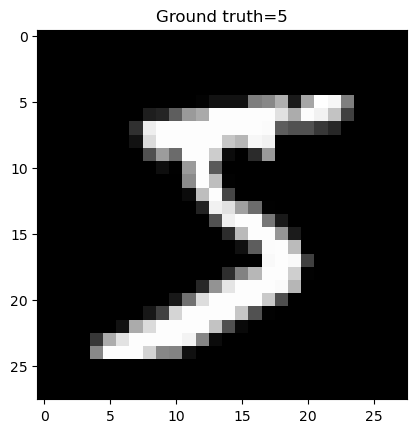

In [3]:
train_loader = MNIST("data", download=True, train=True, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
]))
test_loader = MNIST("data", download=True, train=False, transform=transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
]))
plt.imshow(train_loader[0][0][0], cmap="gray")
plt.title(f"Ground truth={train_loader[0][1]}")

Let's first implement our model class.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class MNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    # Note the use of nn.Sequential here for convenience.
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(784, 800),
      nn.ReLU(),
      nn.Linear(800, 10),
      nn.Softmax(dim=1)
    )

  def forward(self, x):
    return self.layers(x) # Using nn.Sequential makes this easy.

Now we will instantiate our model, loss function, and optimizer:

In [5]:
model = MNISTNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

This time, now that we have a much more powerful engine, we can actually train
our model!

Specifically note that instead of performing full-batch gradient descent, like
we did in `iris.ipynb`, we are using "mini-batch" gradient descent, so that we
aren't training on the entire dataset at once.

In [6]:
for epoch in range(10):
  for i, (x, y) in enumerate(train_loader):
    x = x.to(DEVICE)
    y = torch.tensor(y).to(DEVICE)
    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, torch.tensor([y]))
    loss.backward()
    optimizer.step()
  print(f"Epoch {epoch} loss: {loss}")

Epoch 0 loss: 1.4649088382720947
Epoch 1 loss: 1.4613401889801025
Epoch 2 loss: 1.4611555337905884
Epoch 3 loss: 1.461155652999878
Epoch 4 loss: 1.4611510038375854
Epoch 5 loss: 1.4611507654190063
Epoch 6 loss: 1.4611517190933228
Epoch 7 loss: 1.461150050163269
Epoch 8 loss: 1.461150050163269
Epoch 9 loss: 1.461150050163269


In [8]:
print("Final Accuracy:", sum(torch.argmax(model(x.to(DEVICE)), dim=1) == torch.tensor(y).to(DEVICE) for x, y in test_loader) / len(test_loader))

Final Accuracy: tensor([0.9801])


Now that our model is trained, try running it on some test examples, and see how it does!

Text(0.5, 0, 'Prediction=5')

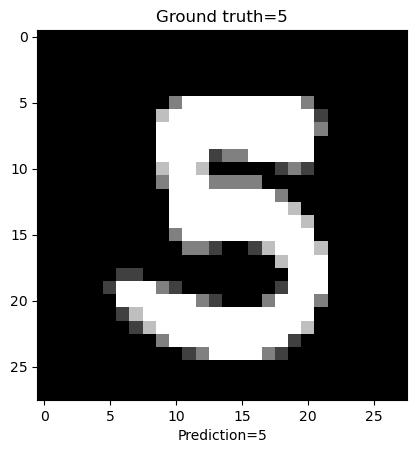

In [13]:
SAMPLE_IDX = 1003
x, y = test_loader[SAMPLE_IDX]
plt.imshow(x[0], cmap="gray")
plt.title(f"Ground truth={y}")
pred = torch.argmax(model(x.to(DEVICE)))
plt.xlabel(f"Prediction={pred}")